# Hybrid model

In [2]:
#!pip install dill
import datetime
import dill
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.8 MB/s eta 0:00:00


In [3]:
PATH_TO_DATA = "/content/data_kion.zip"

with ZipFile(PATH_TO_DATA) as z:

    with z.open("data_kion/interactions_df.csv") as f:
        interactions = pd.read_csv(f)

    with z.open("data_kion/items.csv") as f:
        items = pd.read_csv(f)

    with z.open("data_kion/users.csv") as f:
        users = pd.read_csv(f)

## EDA

In [4]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [5]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())

print(f"Unique users in  interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in  interactions: {interactions['item_id'].nunique():_}")

Unique users in  interactions: 962_179
Unique items in  interactions: 15_706


In [6]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13
max date in interactions: 2021-08-22


In [7]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [8]:
f"Num unique users in users: {users.shape[0]:_}"

'Num unique users in users: 840_197'

In [9]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [10]:
f"Unique items in items {items.shape[0]:_}"

'Unique items in items 15_963'

## Global train_test split

In [11]:
train = interactions[(interactions['last_watch_dt'] < max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['last_watch_dt'] >= max_date - pd.Timedelta(days=7))]

train = train[train['total_dur'] >= 300]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (3832711, 5)
test: (490982, 5)


#### First we will train LightFM user2item

In [12]:
lfm_date_threshold = train['last_watch_dt'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

datetime.date(2021, 7, 6)

In [13]:
lfm_train = train[(train['last_watch_dt'] < lfm_date_threshold)]
lfm_pred = train[(train['last_watch_dt'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (2286604, 5)
lfm_pred: (1546107, 5)


In [14]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]

In [15]:
lfm_pred.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
11,988709,7571,2021-07-07,6558,100.0
16,646903,16228,2021-07-23,57375,46.0
19,215229,7793,2021-08-01,873,14.0
28,81786,2616,2021-07-24,41422,90.0
42,205710,10152,2021-07-20,1946,38.0


In [16]:
lfm_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0


## LightFM train

In [18]:
#!pip install lightfm
from lightfm.data import Dataset
from lightfm import LightFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808327 sha256=8a32658800964fbbc672aef74b1f95fdefb583a625764c279bde040f875fedb7
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [19]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())

In [20]:
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'total_dur']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [21]:
# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 512783
items_mapping amount: 12796


In [22]:
lfm_model = LightFM(
    no_components=64,
    learning_rate=0.1,
    loss='warp',
    max_sampled=5,
    random_state=42
)

In [23]:
num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr,
        num_threads = 4,
        verbose=True
    )

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]

Epoch: 100%|██████████| 1/1 [00:08<00:00,  8.43s/it]

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

Epoch: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

Epoch: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.00s/it]

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]

Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]

Epoch: 100%|██████████| 1/1 [00:08<00:00,  8.34s/it]

Epoch: 100%|██████████| 1/1

In [24]:
weights_matrix_csr

<512783x12796 sparse matrix of type '<class 'numpy.float32'>'
	with 2286604 stored elements in Compressed Sparse Row format>

In [25]:
# save model
with open(f"lfm_model.dill", 'wb') as f:
    dill.dump(lfm_model, f)

## Generate candidates

In [26]:
candidates = pd.DataFrame({
    'user_id': lfm_pred['user_id'].unique()
})

candidates.head(3)

,user_id
0,988709
1,646903
2,215229


In [27]:
def generate_lightfm_recs_mapper(model, item_ids, known_items,
                                 user_features, item_features, N,
                                 user_mapping, item_inv_mapping,
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [28]:

top_N = 20

all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [29]:
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

candidates.head()

,user_id,item_id,rank
0,988709,10440,1
0,988709,15297,2
0,988709,13865,3
0,988709,4151,4
0,988709,9728,5


In [30]:
candidates.shape

(3262560, 3)

## 2nd step. Train Catboost

In [37]:
pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(125727, 7)


(219578, 7)

## Forming train and test for boosting by users and not by date

In [38]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [39]:
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [40]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# eval
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

## let`s check class balance

In [41]:

ctb_train['target'].value_counts(normalize=True)

0    0.637145
1    0.362855
Name: target, dtype: float64

In [42]:
ctb_test['target'].value_counts(normalize=True)

0    0.633107
1    0.366893
Name: target, dtype: float64

## Add new features for our ranking model

In [43]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

In [44]:
train_feat = ctb_train.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

eval_feat = ctb_eval.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

In [45]:
train_feat.head()

,user_id,item_id,rank,target,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,891374,3693,11,0,age_18_24,income_20_40,М,0.0,film,США,NaN,18.0,NaN
1,719804,4151,10,1,age_35_44,income_20_40,М,1.0,series,Россия,NaN,18.0,NaN
2,438134,142,8,0,NaN,NaN,NaN,NaN,film,Россия,NaN,16.0,NaN
3,825172,13865,3,1,NaN,NaN,NaN,NaN,film,Россия,NaN,12.0,NaN
4,957880,7866,18,0,age_45_54,income_0_20,Ж,0.0,film,Германия,NaN,16.0,NaN


In [46]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [47]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [48]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_train.mode().iloc[0])

## CatboostClassifier train

In [62]:
from catboost import CatBoostClassifier

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [63]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740665	test: 0.6744929	best: 0.6744929 (0)	total: 313ms	remaining: 10m 24s
200:	learn: 0.5585568	test: 0.5626197	best: 0.5626172 (199)	total: 1m 3s	remaining: 9m 32s
400:	learn: 0.5569722	test: 0.5619506	best: 0.5619502 (399)	total: 2m 1s	remaining: 8m 4s
600:	learn: 0.5558482	test: 0.5616637	best: 0.5616637 (600)	total: 3m 1s	remaining: 7m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5616112568
bestIteration = 633

Shrink model to first 634 iterations.


In [64]:
# save model
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

## Feature importance

In [67]:
!pip install shap
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=cat_col), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.2 MB/s eta 0:00:00


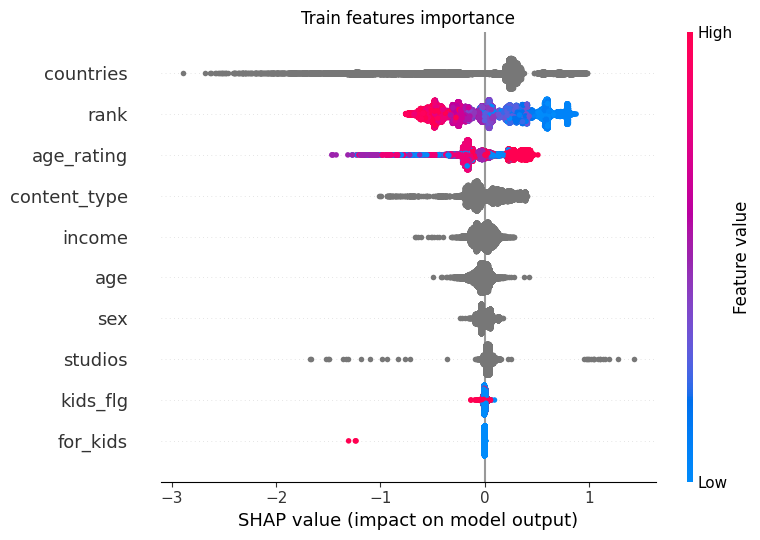

In [68]:
plt.title("Train features importance")

shap.summary_plot(
    shap_values,
    X_train_subs
)

## Catboost metrics

In [69]:
test_feat = ctb_test.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                    .merge(items[item_col],
                               on=['item_id'],
                               how='left')

In [70]:
# fillna for catboost with the most frequent value
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [71]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [72]:
y_pred = ctb_model.predict_proba(X_test)

In [73]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.75'

## Metrics on global test

In [74]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]

In [75]:
top_N = 200

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

known_items = lfm_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1

In [76]:
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]

    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [77]:
lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction,
                              top_N=10)
lfm_metrics

Precision@1     0.026368
Recall@1        0.014886
Precision@2     0.028450
Recall@2        0.032297
Precision@3     0.027301
Recall@3        0.045816
Precision@4     0.026130
Recall@4        0.057858
Precision@5     0.025293
Recall@5        0.069453
Precision@6     0.023842
Recall@6        0.077675
Precision@7     0.022658
Recall@7        0.085139
Precision@8     0.021538
Recall@8        0.091870
Precision@9     0.020481
Recall@9        0.097381
Precision@10    0.019575
Recall@10       0.102580
MAP@10          0.045139
MRR             0.073801
dtype: float64

## Metrics for LightFM + Catboost

In [78]:
lfm_ctb_prediction = lfm_prediction.copy()


score_feat = lfm_ctb_prediction.merge(users[user_col],
                                   on=['user_id'],
                                   how='left')\
                                .merge(items[item_col],
                                       on=['item_id'],
                                       how='left')


score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [79]:
score_feat.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,203219,10440,1,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
1,203219,15297,2,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
2,203219,13865,3,age_35_44,income_20_40,Ж,0.0,film,Россия,0.0,12.0,HBO
3,203219,4151,4,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
4,203219,9728,5,age_35_44,income_20_40,Ж,0.0,film,"Великобритания, США",0.0,18.0,HBO


In [80]:
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,ctb_pred
0,203219,10440,1,0.712418
1,203219,15297,2,0.744204
2,203219,13865,3,0.540615


In [81]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
8807600,21,10440,1
8807728,21,10772,129
8807729,21,12463,130
8807730,21,5805,131
8807731,21,6117,132
8807732,21,14775,133
8807733,21,9214,134
8807734,21,8486,135
8807735,21,3908,136
8807736,21,1574,137


In [82]:
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [83]:
lfm_ctb_prediction.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
8807600,21,10440,1,0.702364,1
8807605,21,9728,6,0.591142,2
8807602,21,13865,3,0.525939,3
8807655,21,11754,56,0.487625,4
8807788,21,5171,189,0.487625,5
8807608,21,15297,9,0.474378,6
8807612,21,4151,13,0.418237,7
8807621,21,4880,22,0.368455,8
8807630,21,9996,31,0.257626,9
8807644,21,2657,45,0.257626,10


In [84]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction,
                                       top_N=10,
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.050316
Recall@1        0.028406
Precision@2     0.044182
Recall@2        0.049752
Precision@3     0.038267
Recall@3        0.064209
Precision@4     0.033413
Recall@4        0.073971
Precision@5     0.029906
Recall@5        0.081963
Precision@6     0.027263
Recall@6        0.088719
Precision@7     0.025220
Recall@7        0.094893
Precision@8     0.023558
Recall@8        0.100504
Precision@9     0.022086
Recall@9        0.105457
Precision@10    0.020764
Recall@10       0.109755
MAP@10          0.058452
MRR             0.096998
dtype: float64

## Metrics comp

In [87]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'hybrid_model']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.026368,0.014886,0.028450,0.032297,0.027301,0.045816,0.026130,0.057858,0.025293,0.069453,...,0.022658,0.085139,0.021538,0.091870,0.020481,0.097381,0.019575,0.102580,0.045139,0.073801
hybrid_model,0.050316,0.028406,0.044182,0.049752,0.038267,0.064209,0.033413,0.073971,0.029906,0.081963,...,0.025220,0.094893,0.023558,0.100504,0.022086,0.105457,0.020764,0.109755,0.058452,0.096998


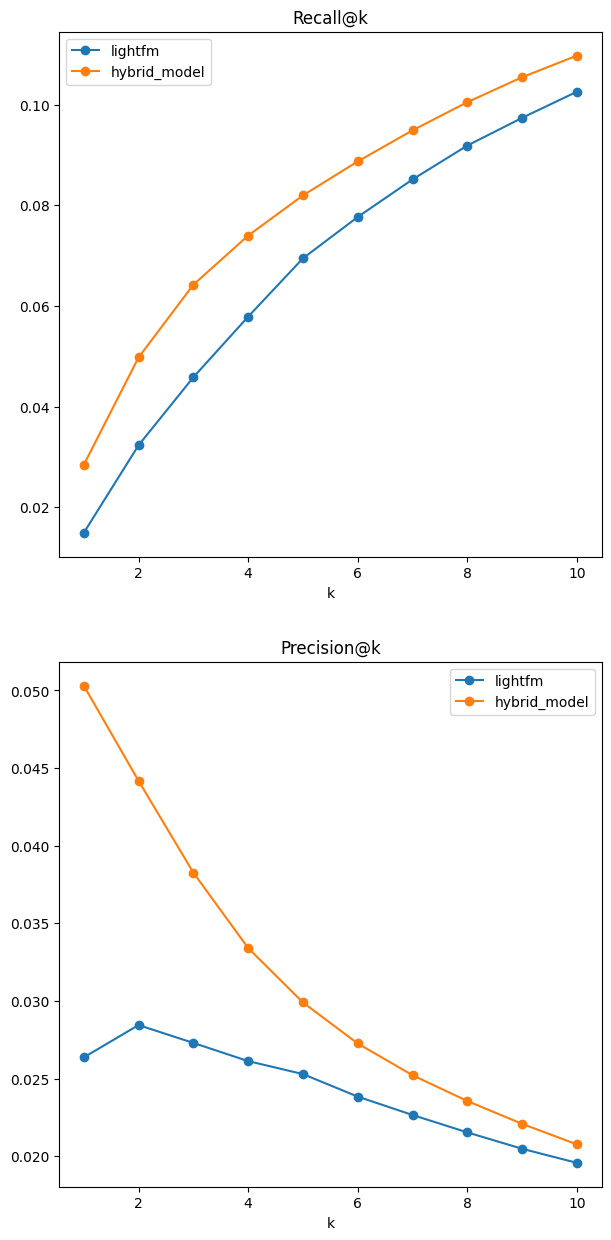

In [88]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11),
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')